In this notebook, we will present how to merge datasets in scVI

In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
use_cuda = True

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset.pbmc import Dataset10X, PbmcDataset

from scvi.inference.posterior import *
from scvi.metrics.clustering import select_indices_evenly, clustering_scores, entropy_batch_mixing
from scipy import sparse
from scvi.models.vae import VAE
from scvi.inference import UnsupervisedTrainer

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from scvi.harmonization.utils_chenling import get_matrix_from_dir,assign_label,run_model
import pandas as pd
from sklearn.preprocessing import scale

In [11]:
adt_expression_clr = pd.read_csv('../cite/ADT_cut_clr.csv')
# adt_expression_clr[adt_expression_clr<0]=0
# adt_expression_clr = scale(adt_expression_clr,with_mean=False)

In [12]:
adt_expression_clr

cellid       CD3       CD4       CD8       CD2    CD45RA  \
0     TGACTAGTCCCAAGTA -0.209240 -0.344505 -0.352159  0.210751 -0.029191   
1     GACCTGGAGTCTCAAC -0.262933 -0.323732 -0.305174  0.146869  0.001036   
2     GATCTAGCATTCTTAC -0.297208 -0.297550 -0.325340  0.191811 -0.004080   
3     CATATGGCATCCCACT -0.254597 -0.304771 -0.344637  0.198355 -0.011056   
4     CACATAGGTCTCCACT -0.298314 -0.382918 -0.181472  0.191055 -0.004009   
5     ATAGACCAGCCAGTAG -0.253345 -0.335865 -0.276118  0.204963  0.007603   
6     CACAGTAAGATCTGCT -0.285585 -0.349589 -0.297575  0.180361 -0.023771   
7     GTTCTCGGTCGTTGTA  0.132979  0.197261 -0.281454  0.513159 -0.518187   
8     CACACCTCAATTGCTG -0.192499 -0.247000 -0.107745  0.148377  0.094192   
9     GGAATAACACGCGAAA -0.099579 -0.029314 -0.301024  0.238969 -0.086341   
10    AACTTTCCAGGTCTCG -0.212832 -0.300453 -0.302494  0.185918 -0.003146   
11    AGTCTTTGTACTCTCC -0.228990 -0.374125 -0.331000  0.192466  0.007399   
12    TCCACACAGAATGTTG -0.270231 -0.289997 -0.309631  0.175852  0.010194   
13    TAAGTGCTCTCGTATT  0.191198  0.204858 -0.236414  0.460759 -0.531603   
14    AAGGAGCGTTTAGGAA -0.233713 -0.347485 -0.065672  0.130917  0.046751   
15    TGCACCTCAGGATCGA -0.255496 -0.376496 -0.277355  0.192310 -0.000234   
16    AAACCTGTCAGCACAT -0.248933 -0.283399 -0.264525  0.244284  0.288392   
17    TTCTTAGCATATACGC -0.288655 -0.271147 -0.006560  0.320984  0.015214   
18    TCGAGGCTCTGCTTGC  0.127578 -0.300322  0.297717  0.403795 -0.539042   
19    GAATAAGAGTCTCGGC  0.143889  0.103459 -0.370705  0.333549 -0.255685   
20    GTGCATATCGGTTAAC -0.265291 -0.359820  0.050063  0.355219 -0.012775   
21    AGTGTCAGTGTTTGGT  0.013132 -0.030519 -0.133371  0.483683 -0.286707   
22    CGCGGTAGTGTCCTCT -0.215610 -0.409152 -0.202461  0.204160  0.005531   
23    CGGTTAAGTGTTCTTT -0.303623 -0.322370 -0.259102  0.188617  0.009731   
24    AGAGCTTCACCGTTGG -0.256829 -0.328009 -0.303759  0.181506  0.010402   
25    TCGTACCCAAAGGTGC -0.305453 -0.344655 -0.289312  0.154009  0.026287   
26    GTAACTGGTGATGCCC -0.272430 -0.341466 -0.247523  0.183602  0.025205   
27    TTCTTAGGTAGTACCT  0.064617  0.108213 -0.187036  0.338227 -0.449105   
28    AGAGCTTAGGACGAAA -0.245299 -0.368630 -0.334927  0.136224  0.025648   
29    CACACAAAGACAGAGA  0.061743 -0.315256 -0.319585  0.272248 -0.143270   
...                ...       ...       ...       ...       ...       ...   
7637  CGTGTAACAACCGCCA  0.165913  0.111412 -0.337947  0.308362 -0.260475   
7638  TGGTTAGCAAGCCTAT -0.209352 -0.034795  0.027190  0.174015 -0.455716   
7639  CCAATCCAGCTGGAAC -0.339395  0.056820 -0.174743  0.153819 -0.570145   
7640  GTATTCTTCGTGGGAA  0.033919 -0.008503 -0.284145  0.218410  0.081386   
7641  GTCACAAGTCCCTACT -0.301201 -0.026777  0.154534  0.079714 -0.470664   
7642  CGTGTAACATCACGAT -0.289756 -0.381554  0.163389  0.327695 -0.098576   
7643  TTTACTGCAAGCTGAG -0.251158 -0.285382  0.151273  0.267697 -0.026463   
7644  CGTGTAATCAAGCCTA  0.024376 -0.353563  0.216237  0.384721 -0.510028   
7645  CAACTAGAGAGTAAGG -0.206792 -0.095588 -0.043960 -0.024326 -0.148230   
7646  TCAGGTACAAGCGATG -0.315787 -0.275279 -0.054796  0.198681  0.141595   
7647  TCAGATGGTGCATCTA -0.298070 -0.007149 -0.089270 -0.006205 -0.236960   
7648  ATTTCTGGTTTGGGCC -0.222075 -0.306723 -0.307596 -0.026840  0.018993   
7649  TTAGGCAAGTATCTCG -0.237703 -0.017634  0.077065  0.117312 -0.446956   
7650  TGGCGCAAGAGCTATA -0.262992  0.107033  0.026546  0.060454 -0.427697   
7651  AGTCTTTCACTTAAGC -0.316386  0.009514 -0.019493  0.018978 -0.421681   
7652  CAGAGAGCACGGCTAC -0.246001 -0.166177  0.096602  0.122706 -0.123918   
7653  ACGAGGACAAAGGCGT -0.219130 -0.168550  0.175249  0.205280 -0.386375   
7654  GTACTTTGTTCGTGAT -0.277098 -0.190258  0.145929  0.011519 -0.179994   
7655  GTAACGTTCTGCAGTA -0.363220  0.097257 -0.111412 -0.089943 -0.470668   
7656  AGTCTTTTCTCGATGA  0.142314  0.121938 -0.335556  0.411904 -0.353380   
7657  CTCGGGACATAGAAAC -0.273110 -0.017612  0.016764  0.017807 -

In [18]:
count, geneid, cellid = get_matrix_from_dir('cite')
count = count.T.tocsr()
seurat = np.genfromtxt('../cite/cite.seurat.labels', dtype='str', delimiter=',')
cellid = np.asarray([x.split('-')[0] for x in cellid])
labels_map = [0, 0, 1, 2, 3, 4, 5, 6]
labels = seurat[1:, 4]
cell_type = ["CD4 T cells", "NK cells", "CD14+ Monocytes", "B cells", "CD8 T cells", "FCGR3A Monocyte", "na"]
cite = assign_label(cellid, geneid, labels_map, count, cell_type, seurat)

In [140]:
x = seurat[1,5]

In [152]:
dat = [adt_expression_clr.loc[adt_expression_clr['cellid'] == x] for x in seurat[1:,5]]

In [157]:
protein = pd.concat(dat)

In [20]:
cite.cell_types

array(['CD4 T cells', 'NK cells', 'CD14+ Monocytes', 'B cells',
       'CD8 T cells', 'FCGR3A Monocyte', 'na'], dtype='<U15')

In [21]:
cell_types = np.array(["cd4_t_helper", "regulatory_t", "naive_t", "memory_t", "cytotoxic_t", "naive_cytotoxic",
                       "b_cells", "cd34", "cd56_nk", "cd14_monocytes"])
cell_type_name = np.array(["CD4 T cells", "CD4 T cells Regulatory", "CD4 T cells Naive", "CD4 Memory T cells", "CD8 T cells", "CD8 T cells Naive",
                       "B cells", "CD34 cells", "NK cells", "CD14+ Monocytes"])

datasets = []
for i,cell_type in enumerate(cell_types):
    dataset = Dataset10X(cell_type, save_path='data/')
    dataset.cell_types = np.array([cell_type_name[i]])
    dataset.subsample_genes(dataset.nb_genes)
    dataset.gene_names = dataset.gene_symbols
    datasets += [dataset]

pure = GeneExpressionDataset.concat_datasets(*datasets, shared_batches=True)


File data/10X/cd4_t_helper/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16049 genes
Downsampling from 11213 to 11213 cells
File data/10X/regulatory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15950 genes
Downsampling from 10263 to 10263 cells
File data/10X/naive_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15565 genes
Downsampling from 10479 to 10479 cells
File data/10X/memory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16169 genes
Downsampling from 10224 to 10224 cells
File data/10X/cytotoxic_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16130 genes

In [30]:
donor = Dataset10X('fresh_68k_pbmc_donor_a')
donor.cell_types = ['unlabelled']
donor.gene_names = donor.gene_symbols

File data/10X/fresh_68k_pbmc_donor_a/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [166]:
import urllib.request


In [ ]:
annotation_url = 'https://raw.githubusercontent.com/10XGenomics/single-cell-3prime-paper/master/pbmc68k_analysis/68k_pbmc_barcodes_annotation.tsv'
urllib.request.urlretrieve(annotation_url, 'data/10X/fresh_68k_pbmc_donor_a/
')  


In [35]:
gene_dataset = GeneExpressionDataset.concat_datasets(cite,donor, pure)

Keeping 11300 genes


In [36]:
gene_dataset.X.shape

(169850, 11300)

In [37]:
gene_dataset.cell_types

array(['CD4 T cells Regulatory', 'CD8 T cells', 'CD34 cells',
       'CD4 Memory T cells', 'CD4 T cells', 'CD8 T cells Naive',
       'B cells', 'na', 'NK cells', 'FCGR3A Monocyte', 'CD14+ Monocytes',
       'unlabelled', 'CD4 T cells Naive'], dtype='<U22')

In [39]:
plotname='CiteDonorPure'
latent, batch_indices, labels, keys, stats = run_model(
    'writedata', gene_dataset, 0, 0,filename=plotname)

In [44]:
def subsetByGenenames(dataset, subsetnames):
    genenames = dataset.gene_names
    filter = np.asarray([x in subsetnames for x in genenames])
    dataset.X = dataset.X[:, filter]
    dataset.update_genes(np.arange(len(filter))[filter])
    return dataset

def SubsetGenes(dataset1,dataset2,dataset3,gene_dataset,plotname,ngenes=1000):
    import pandas as pd
    genes1 = pd.read_table('../Seurat_data/' + plotname + '.1.hvg_info.csv', delimiter=',')
    geneid1 = np.asarray([x.replace('gene_', '') for x in genes1[genes1.keys()[0]]]).astype('int')
    genenames1 = genes1['genename']
    genes2 = pd.read_table('../Seurat_data/' + plotname + '.2.hvg_info.csv', delimiter=',')
    geneid2 = np.asarray([x.replace('gene_', '') for x in genes2[genes2.keys()[0]]]).astype('int')
    genenames2 = genes2['genename']
    genes3 = pd.read_table('../Seurat_data/' + plotname + '.3.hvg_info.csv', delimiter=',')
    geneid3 = np.asarray([x.replace('gene_', '') for x in genes3[genes3.keys()[0]]]).astype('int')
    genenames3 = genes3['genename']
    assert np.sum(np.asarray(genenames1) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    assert np.sum(np.asarray(genenames2) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    assert np.sum(np.asarray(genenames3) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    geneid = np.union1d(np.union1d(geneid1[:ngenes], geneid2[:ngenes]),geneid3[:ngenes]) - 1
    genes = gene_dataset.gene_names[geneid]
    dataset1 = subsetByGenenames(dataset1,genes)
    dataset2 = subsetByGenenames(dataset2,genes)
    dataset3 = subsetByGenenames(dataset2,genes)
    gene_dataset = subsetByGenenames(gene_dataset,genes)
    return dataset1,dataset2,dataset3,gene_dataset


In [45]:
cite,donor,pure,gene_dataset = SubsetGenes(cite,donor,pure,gene_dataset,'CiteDonorPure')

Downsampling from 17014 to 2071 genes
Downsampling from 6616 to 6616 cells
Downsampling from 32738 to 2071 genes
Downsampling from 68579 to 68579 cells
Downsampling from 2071 to 2071 genes
Downsampling from 68579 to 68579 cells
Downsampling from 11300 to 2071 genes
Downsampling from 169850 to 169850 cells


In [46]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=100)

training: 100%|██████████| 100/100 [25:37<00:00, 15.38s/it]


In [47]:
import torch
torch.save(trainer.model,'../models/CiteDonorPure.vae.pkl')

In [91]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
# latent, idx_t_sne = trainer.train_set.apply_t_sne(latent, 10000)

In [92]:
batch_indices = batch_indices.ravel()
np.unique(batch_indices)

array([0, 1, 2])

In [98]:
from scvi.metrics.clustering import select_indices_evenly
from sklearn.manifold import TSNE
import seaborn as sns

citeidx = np.arange(len(batch_indices))[batch_indices==0]
sample = np.unique(np.concatenate([select_indices_evenly(2000, labels),np.arange(len(batch_indices))[batch_indices==0]]))

In [99]:
colors = sns.color_palette('tab20')
latent_s = latent[sample, :]
label_s = labels[sample]
batch_s = batch_indices[sample]


In [100]:
if latent_s.shape[1] != 2:
    latent_s = TSNE().fit_transform(latent_s)

In [101]:
latent_s.shape

(27170, 2)

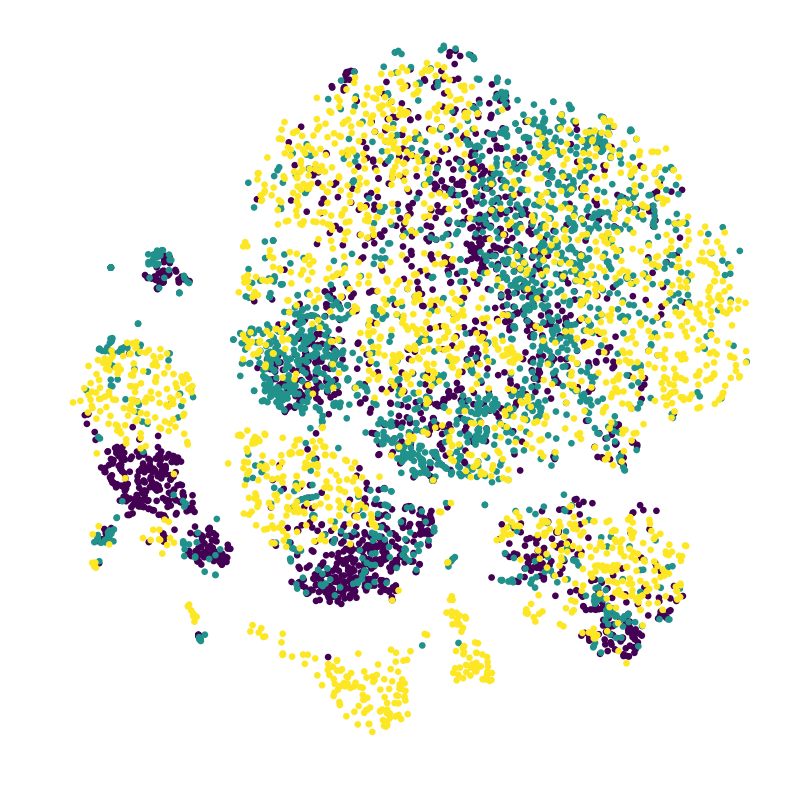

In [102]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
batch_s = batch_s.ravel()
temp = select_indices_evenly(2000, batch_s)

plt.scatter(latent_s[temp, 0], latent_s[temp, 1], c=batch_s[temp], edgecolors='none')
plt.axis("off")
plt.tight_layout()
plt.show()

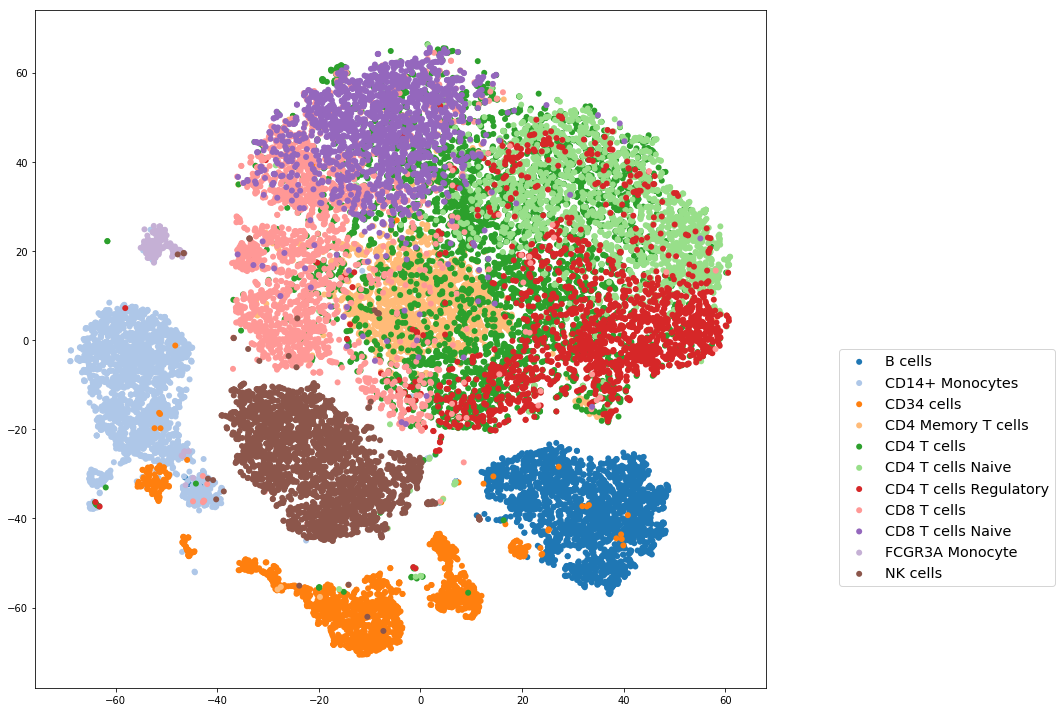

In [103]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(15, 10))
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        ax.scatter(latent_s[label_s == k, 0], latent_s[label_s == k, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
        ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
fig.tight_layout()


In [160]:
protein.columns.values

array(['cellid', 'CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16',
       'CD14', 'CD11c', 'CD19'], dtype=object)

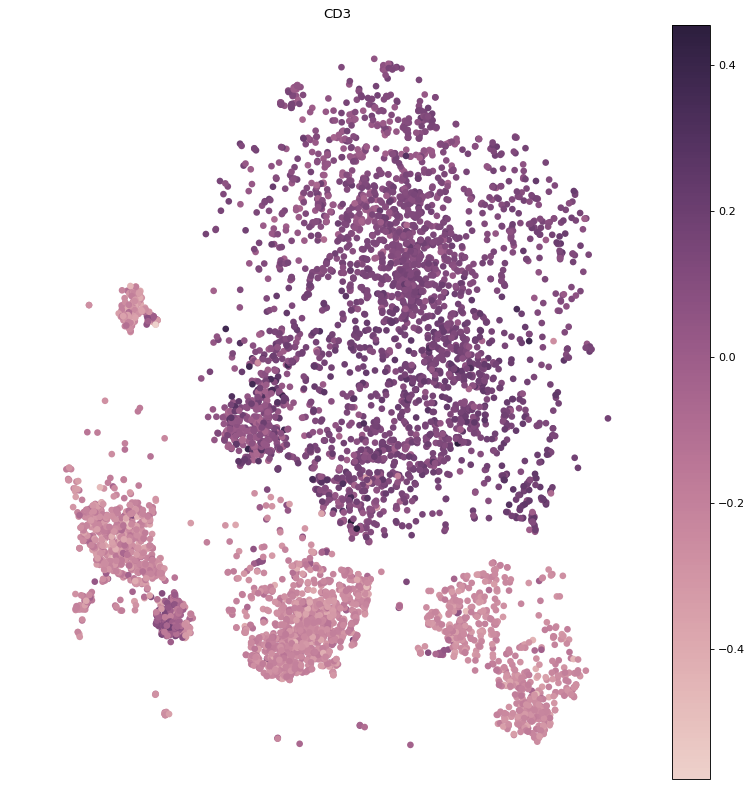

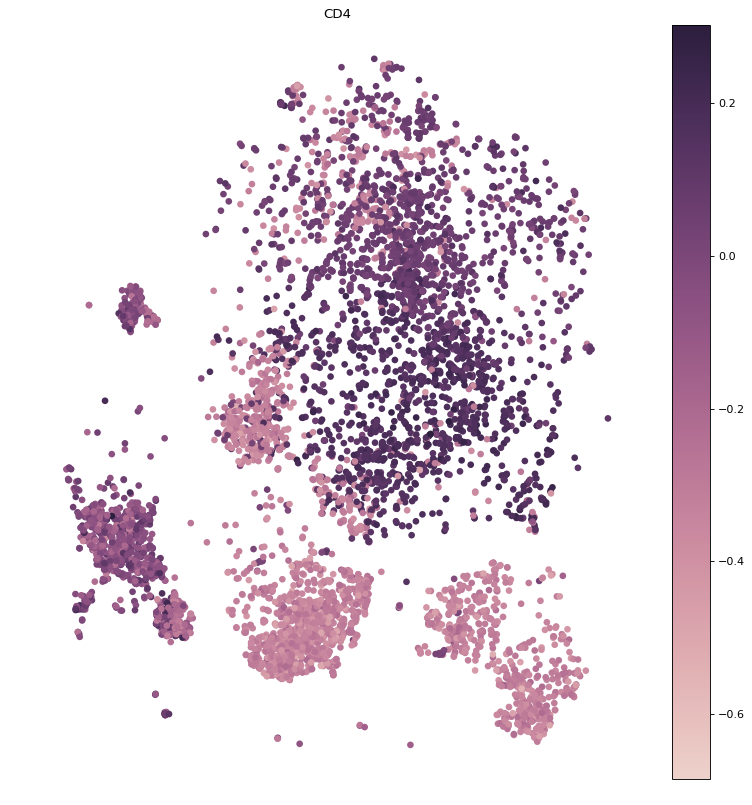

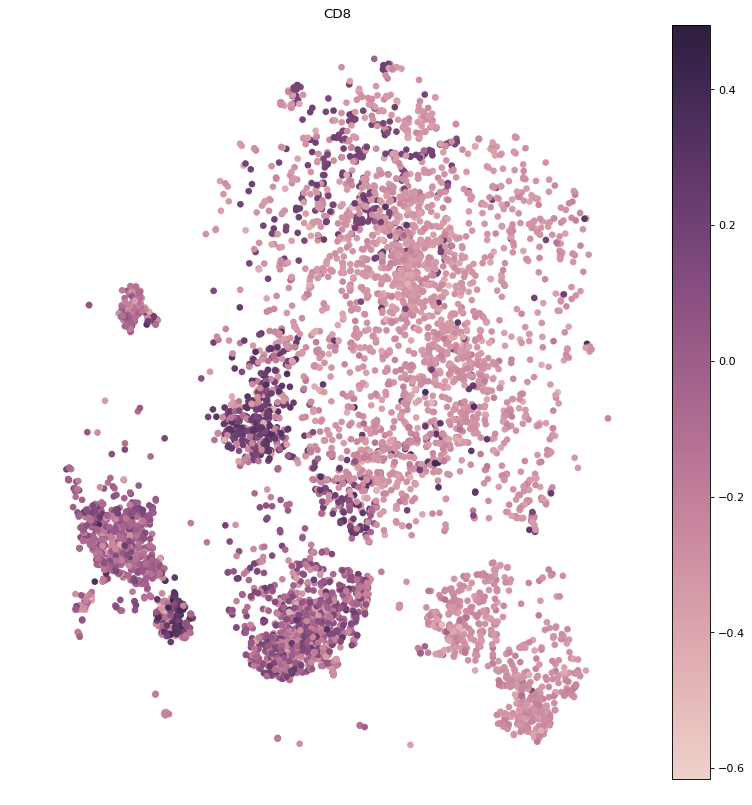

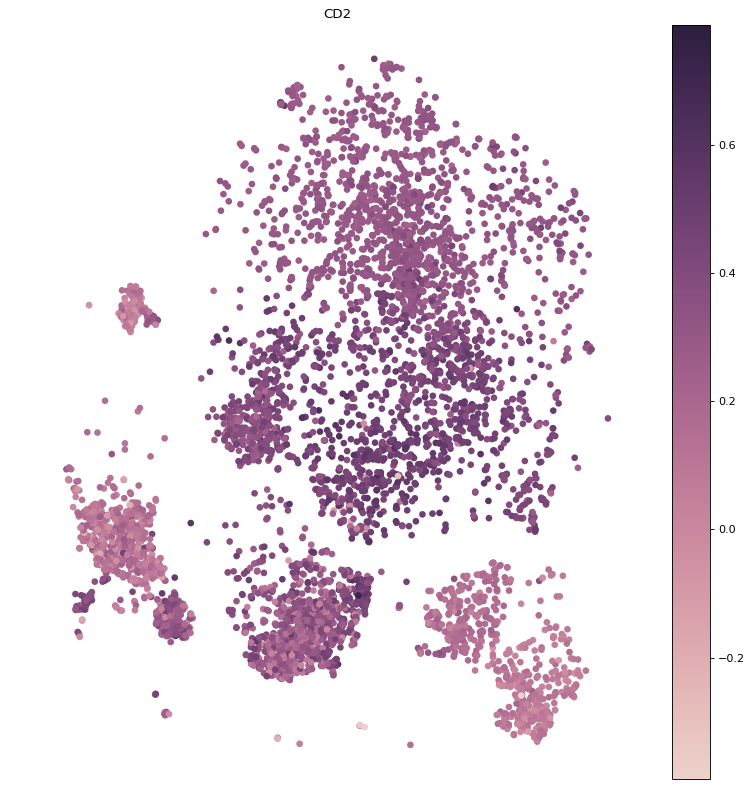

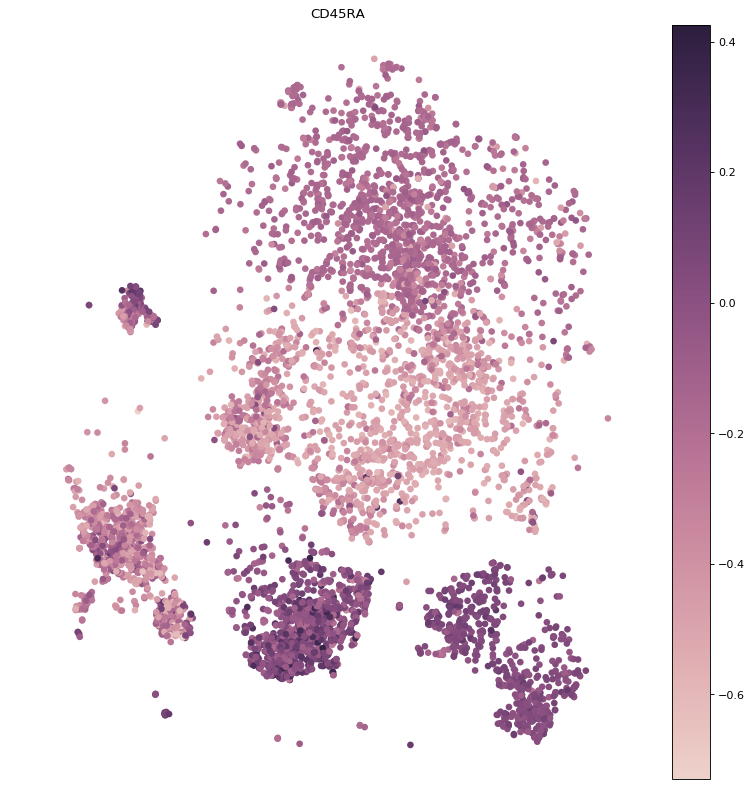

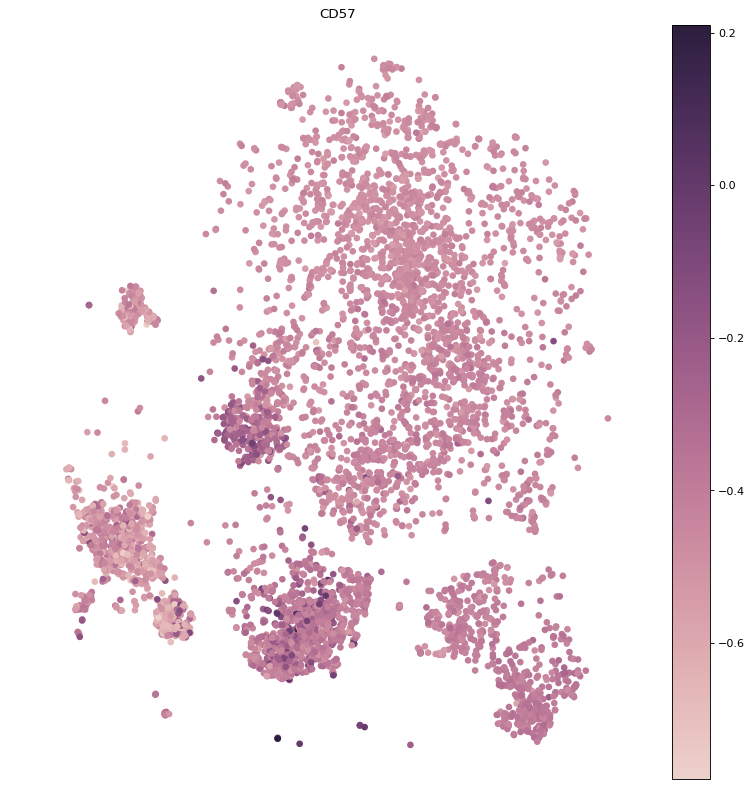

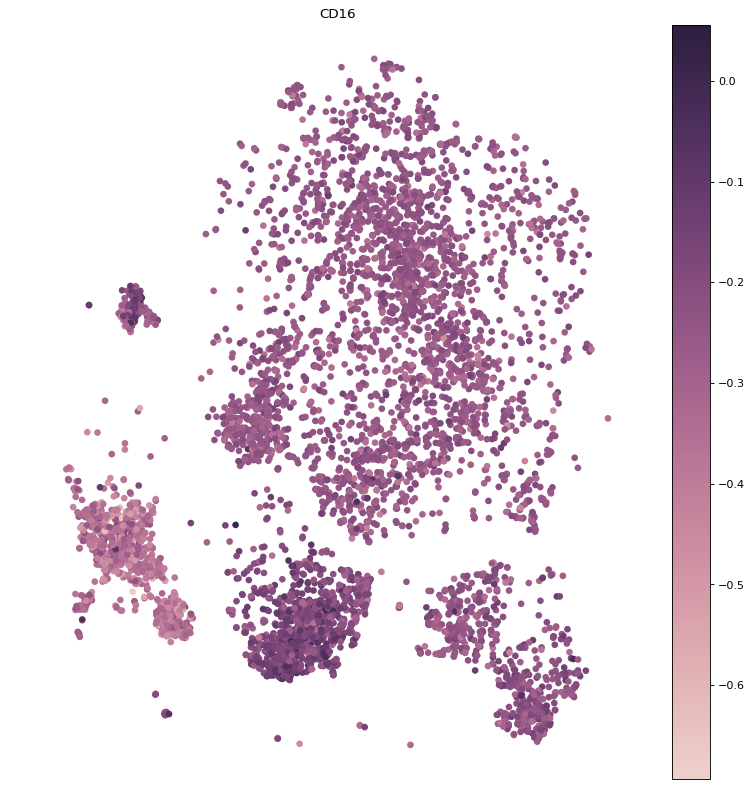

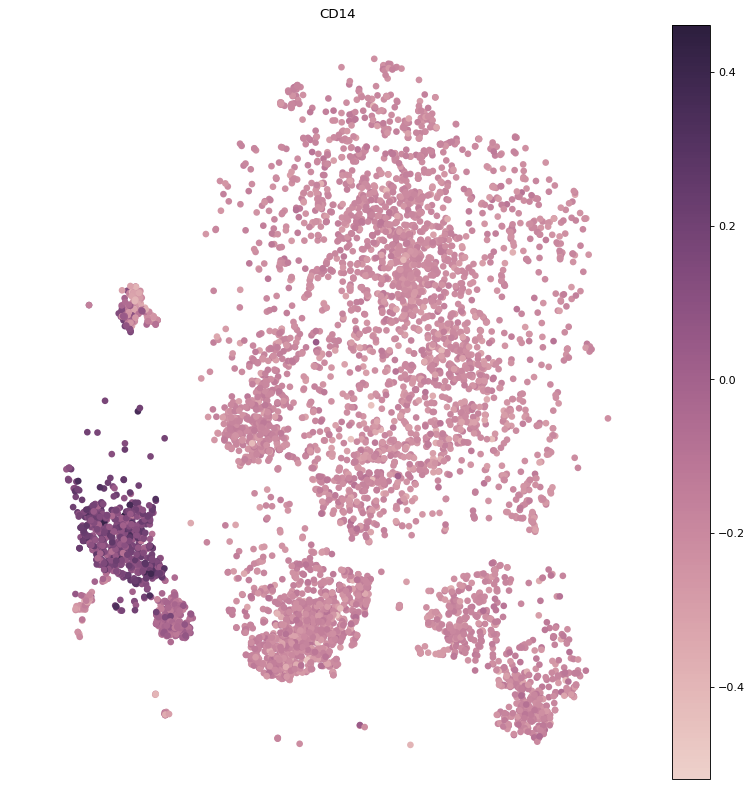

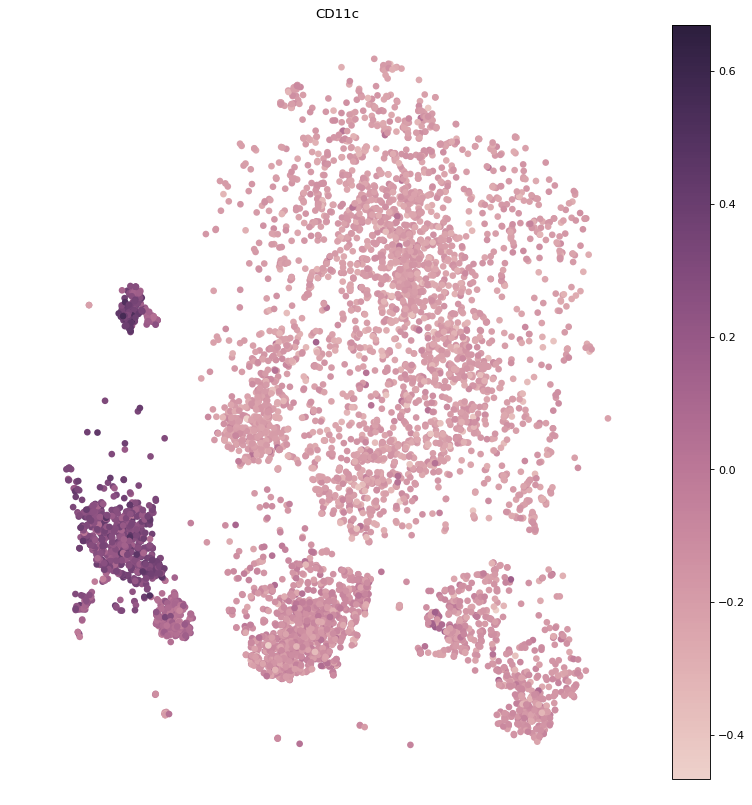

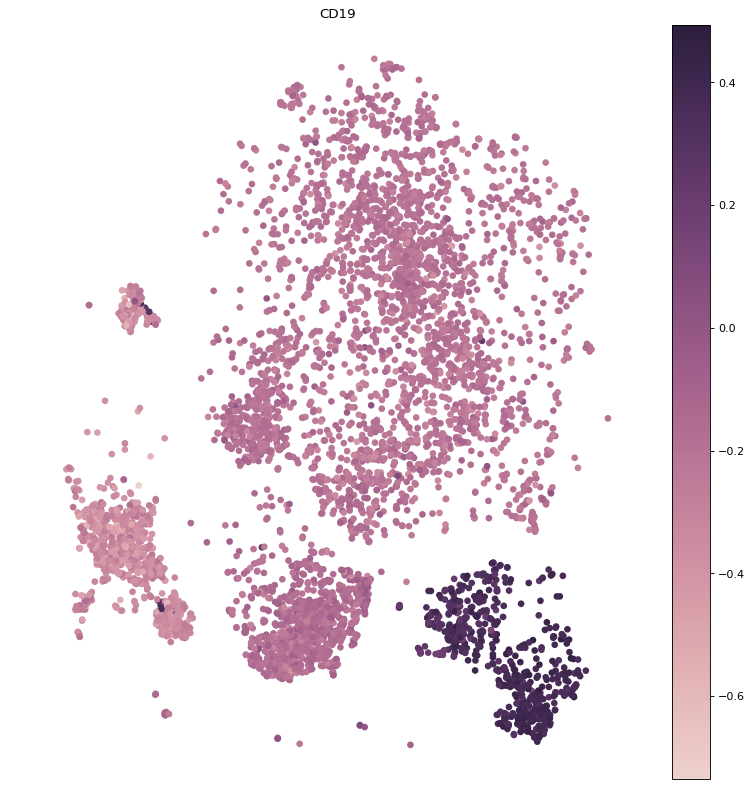

In [165]:
for marker in protein.columns.values[1:]:
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    batch_s = batch_s.ravel()
    sample = select_indices_evenly(2000, batch_s)
    plt.scatter(latent_s[np.arange(len(cite)), 0], latent_s[np.arange(len(cite)), 1], 
                c=np.asarray(protein[marker]), cmap = sns.cubehelix_palette(as_cmap=True),edgecolors='none')
    plt.axis("off")
    plt.colorbar()
    plt.tight_layout()
    plt.title(marker)
    plt.show()